In [13]:
import pandas as pd
from pathlib import Path
import timeit
import gc

from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt  
from sklearn import metrics

import lightgbm as lgb

from dataclasses import dataclass
from typing import Any

In [3]:
! pip install matplotlib

     |████████████████████████████████| 10.3 MB 18.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 65.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 66.1 MB/s eta 0:00:01


In [5]:
processed_path = Path('/data/processed')
processed_path.mkdir(parents=True, exist_ok=True)

In [6]:
import pickle
with open(processed_path/'final-train_x.pickle','rb') as f: train_x = pickle.load(f)
with open(processed_path/'final-train_target_3_day.pickle','rb') as f: train_target_3_day = pickle.load(f)
with open(processed_path/'final-train_target_7_day.pickle','rb') as f: train_target_7_day = pickle.load(f)
with open(processed_path/'final-train_idens.pickle','rb') as f: train_idens = pickle.load(f)

with open(processed_path/'final-valid_x.pickle','rb') as f: valid_x = pickle.load(f)
with open(processed_path/'final-valid_target_3_day.pickle','rb') as f: valid_target_3_day = pickle.load(f)
with open(processed_path/'final-valid_target_7_day.pickle','rb') as f: valid_target_7_day = pickle.load(f)
with open(processed_path/'final-valid_idens.pickle','rb') as f: valid_idens = pickle.load(f)

with open(processed_path/'final-test_x.pickle','rb') as f: test_x = pickle.load(f)
with open(processed_path/'final-test_target_3_day.pickle','rb') as f: test_target_3_day = pickle.load(f)
with open(processed_path/'final-test_target_7_day.pickle','rb') as f: test_target_7_day = pickle.load(f)
with open(processed_path/'final-test_idens.pickle','rb') as f: test_idens = pickle.load(f)

with open(processed_path/'final-na_filler.pickle', 'rb') as f: na_filler = pickle.load(f)

In [7]:
print('na_fillers column count: ', len(na_filler.keys()))
print('feature column count: ', len(train_x.columns))

na_fillers column count:  846
feature column count:  2119


In [8]:
train_x.head()

,demo_gender,demo_age_in_days,demo_primarylanguage_English,demo_primarylanguage_Unknown,"demo_race_Black, not of Hispanic origin","demo_race_White, not of Hispanic origin",demo_education_8th Grade/less,demo_education_9-11 Grades,demo_education_High School,demo_education_Some College,...,notes_unit_190_ewm,notes_unit_191_ewm,notes_unit_192_ewm,notes_unit_193_ewm,notes_unit_194_ewm,notes_unit_195_ewm,notes_unit_196_ewm,notes_unit_197_ewm,notes_unit_198_ewm,notes_unit_199_ewm
0,1.0,31101.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.073884,0.031662,-0.078336,0.061981,0.045825,-0.085382,0.086746,0.157267,-0.026917,-0.134992
1,0.0,30857.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.108582,0.000015,-0.218636,0.241799,0.354505,-0.004352,0.374407,0.413480,0.088190,-0.195880
2,0.0,28581.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-0.071454,0.109990,-0.143386,0.243627,-0.009050,-0.001004,-0.076748,0.332281,-0.212558,0.053445
3,0.0,28600.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.134823,0.001015,-0.196766,0.145058,0.088151,-0.006935,0.039209,0.189289,-0.000860,-0.194074
4,1.0,10730.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.155503,0.106862,-0.046910,-0.053610,-0.087542,-0.026896,0.046498,0.108741,0.034162,-0.071342


In [9]:
train_data = lgb.Dataset(train_x, label=train_target_3_day)
valid_data = lgb.Dataset(valid_x, label=valid_target_3_day)


## ============= Set the Experiment name correctly =============

In [10]:
""" Calculate how many transfers were caught up to a particular rank.
hospital_cumsum - how many transfers caught upto a certain rank. Eg: Caught transfers till 10 th rank
Relavant - total transfers per day per facility
"""

def precision_recall_at_k(group):
    group.loc[:, "hospitalized_cumsum"] = group.hospitalized_within_pred_range.cumsum()
    group.loc[:, "total_relevant"] = group.hospitalized_within_pred_range.sum()
    group.loc[:, "recall_at_k"] = group.hospitalized_cumsum / group.total_relevant

    return group.reset_index(drop=True)

In [11]:
def f_beta_score(precision, recall, beta=2):
    return ((1+beta**2)*(precision*recall)) / ((beta**2)*precision + recall)

In [14]:
params = {
 'application': 'binary',
 'objective': 'binary',
 'metric': 'auc',
 #'boosting_type': hp.choice('boosting_type', ['gbdt']),
 #'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
 'learning_rate': 0.01,
 #'max_depth': hp.quniform('max_depth', -1, 10, 1),
 #'min_child_samples': 20,
 #'min_child_weight': 0.001,
 #'min_split_gain': 0.0,
 'n_estimators': 108,
 'n_jobs': -1,
#  'num_leaves': hp.quniform('num_leaves', 30, 300, 1),
 #'subsample': hp.uniform('subsample', 0, 1),
 #'subsample_for_bin': hp.quniform('subsample_for_bin', 200000, 500000, 1000),
 'verbose': 3,
 'is_unbalance': True,
 #'max_bin': hp.quniform('max_bin', 100,1000, 100),
 'early_stopping_round': None,
}

=============================Training started...=============================


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.82365
[2]	valid_0's auc: 0.827129
[3]	valid_0's auc: 0.832852
[4]	valid_0's auc: 0.834321
[5]	valid_0's auc: 0.835952
[6]	valid_0's auc: 0.837282
[7]	valid_0's auc: 0.838744
[8]	valid_0's auc: 0.840197
[9]	valid_0's auc: 0.841139
[10]	valid_0's auc: 0.841559
[11]	valid_0's auc: 0.841734
[12]	valid_0's auc: 0.842292
[13]	valid_0's auc: 0.842604
[14]	valid_0's auc: 0.842954
[15]	valid_0's auc: 0.843293
[16]	valid_0's auc: 0.84353
[17]	valid_0's auc: 0.843808
[18]	valid_0's auc: 0.843918
[19]	valid_0's auc: 0.843932
[20]	valid_0's auc: 0.844418
[21]	valid_0's auc: 0.844576
[22]	valid_0's auc: 0.844975
[23]	valid_0's auc: 0.844854
[24]	valid_0's auc: 0.844892
[25]	valid_0's auc: 0.844922
[26]	valid_0's auc: 0.844825
[27]	valid_0's auc: 0.844718
[28]	valid_0's auc: 0.845069
[29]	valid_0's auc: 0.845031
[30]	valid_0's auc: 0.845175
[31]	valid_0's auc: 0.845386
[32]	valid_0's auc: 0.845513
[33]	valid_0's auc: 0.845564
[34]	valid_0's auc: 0.845515
[35]	valid_0's auc: 0.845

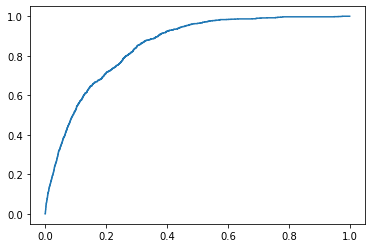

In [15]:

print("=============================Training started...=============================")
model = lgb.train(params, train_set=train_data, valid_sets=[valid_data])

print("=============================Training completed...=============================")
gc.collect()

# ===========================Predict on valdation dataset=======================
valid_preds = model.predict(valid_x)
print("=============================Prediction completed...=============================")

total_valid_aucroc = roc_auc_score(valid_target_3_day, valid_preds)
total_valid_aucroc_25_fpr = roc_auc_score(valid_target_3_day, valid_preds, max_fpr=0.25)
total_valid_ap = average_precision_score(valid_target_3_day, valid_preds)
agg_recall_to_optimize = None

print("=============================TOTAL=============================")
print('total_valid_aucroc', total_valid_aucroc)
print('total_valid_ap', total_valid_ap)
print('total_valid_aucroc_at_.25_fpr', total_valid_aucroc_25_fpr)


fpr, tpr, thresh = metrics.roc_curve(valid_target_3_day, valid_preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(total_valid_aucroc))

# valid_base = valid_idens.copy()
# valid_base['predictionvalue'] = valid_preds
# valid_base['hospitalized_within_pred_range'] = valid_target_3_day
# valid_base['predictionrank'] = valid_base.groupby(['censusdate', 'facilityid']).predictionvalue.rank(ascending=False)
# valid_base = valid_base.sort_values('predictionrank', ascending=True)

# performance_base = (
#     valid_base.groupby(["facilityid", "censusdate"])
#     .apply(precision_recall_at_k)
#     .reset_index(drop=True)
# )

# # Get max rank per facility
# facility_pats = performance_base.groupby(['censusdate','facilityid']
#                 ).predictionrank.max().reset_index().groupby('facilityid').predictionrank.median().reset_index()

# total_facility_recall = 0 

# for facilityid in sorted(valid_idens.facilityid.unique()):
#     mask = (valid_idens.facilityid == facilityid).values
#     k_at_10_percent = round(facility_pats.loc[facility_pats.facilityid == facilityid].predictionrank * .1).values[0]
#     k_at_15_percent = round(facility_pats.loc[facility_pats.facilityid == facilityid].predictionrank * .15).values[0]
#     k_at_20_percent = round(facility_pats.loc[facility_pats.facilityid == facilityid].predictionrank * .2).values[0]

#     rank_subset = performance_base.loc[(performance_base.facilityid==facilityid)]
#     try:
#         print(f"=============================FACILITY - {facilityid}=============================")
#         print(f'facility_{facilityid}_valid_aucroc', roc_auc_score(valid_target_3_day[mask], valid_preds[mask]))
#         print(f'facility_{facilityid}_valid_aucroc_at_.25_fpr', roc_auc_score(valid_target_3_day[mask], valid_preds[mask], max_fpr=0.25))
#         print(f'facility_{facilityid}_valid_ap', average_precision_score(valid_target_3_day[mask],valid_preds[mask]))

#         # We know the total tranfers & caught tranfers upto a certain rank.
#         # Recall can be calculated as sum of all transfers upto a certian rank for entire given date range divided
#         # by sum of total tranfers per day for the entire given date range
#         facility_predicted_sum = rank_subset.loc[rank_subset.predictionrank == k_at_10_percent].hospitalized_cumsum.sum()
#         facility_transfered_sum = rank_subset.loc[rank_subset.predictionrank == k_at_10_percent].total_relevant.sum()
#         agg_recall_at_10_percent = facility_predicted_sum / facility_transfered_sum
#         agg_precision_at_10_percent = facility_predicted_sum / k_at_10_percent

#         facility_predicted_sum = rank_subset.loc[rank_subset.predictionrank == k_at_15_percent].hospitalized_cumsum.sum()
#         facility_transfered_sum = rank_subset.loc[rank_subset.predictionrank == k_at_15_percent].total_relevant.sum()
#         agg_recall_at_15_percent = facility_predicted_sum / facility_transfered_sum
#         agg_precision_at_15_percent = facility_predicted_sum / k_at_15_percent

#         facility_predicted_sum = rank_subset.loc[rank_subset.predictionrank == k_at_20_percent].hospitalized_cumsum.sum()
#         facility_transfered_sum = rank_subset.loc[rank_subset.predictionrank == k_at_20_percent].total_relevant.sum()
#         agg_recall_at_20_percent = facility_predicted_sum / facility_transfered_sum
#         agg_precision_at_20_percent = facility_predicted_sum / k_at_20_percent

#         facility_15_ranks = rank_subset.loc[rank_subset.predictionrank == 15]
#         # add all the recalls at a facility level
#         total_facility_recall += facility_15_ranks.recall_at_k.sum() / facility_15_ranks.recall_at_k.count()

#         print(f'facility_{facilityid}_agg_recall_at_10_percent', agg_recall_at_10_percent)
#         print(f'facility_{facilityid}_agg_b-score_at_10_percent',
#                    f_beta_score(agg_precision_at_10_percent, agg_recall_at_10_percent))
#         print(f'facility_{facilityid}_agg_recall_at_15_percent', agg_recall_at_15_percent)
#         print(f'facility_{facilityid}_agg_b-score_at_15_percent',
#                    f_beta_score(agg_precision_at_15_percent, agg_recall_at_15_percent))
#         print(f'facility_{facilityid}_agg_recall_at_20_percent', agg_recall_at_20_percent)
#         print(f'facility_{facilityid}_agg_b-score_at_20_percent',
#                    f_beta_score(agg_precision_at_20_percent, agg_recall_at_20_percent))

#         if params.get('facility_to_optimize_for') == facilityid:
#             agg_recall_to_optimize = agg_recall_at_15_percent

#     except Exception as e:
#         # workaround for infinity-benchmark because you cannot calculate facility level
#         # metric for one facility.  This workaround will just skip calculating that
#         # facility level metric - it will print the exception, but continue
#         print(e)
#         continue

# print(f"=============================TOTAL RECALL=============================")        
# # divide total_facility_recall by total facilities
# print(f'total_recall_at_rank_15', (total_facility_recall/facility_pats.shape[0]))
